현재 사용 장치: cpu
총 발견된 파일 개수: 46개
[0/46] 데이터 처리 중... 현재 파일: 13_20140603.mat
[5/46] 데이터 처리 중... 현재 파일: 12_20131201.mat
[10/46] 데이터 처리 중... 현재 파일: 8_20140521.mat
[15/46] 데이터 처리 중... 현재 파일: 13_20140610.mat
[20/46] 데이터 처리 중... 현재 파일: 6_20131113.mat
[25/46] 데이터 처리 중... 현재 파일: 5_20140506.mat
[30/46] 데이터 처리 중... 현재 파일: 7_20131027.mat
[35/46] 데이터 처리 중... 현재 파일: 10_20131211.mat
[40/46] 데이터 처리 중... 현재 파일: 10_20131204.mat
[45/46] 데이터 처리 중... 현재 파일: 1_20131030.mat

로드 및 전처리 완료
Target(나) 데이터: (1704, 62, 800) (클래스 0/1 비율: [834 870])
Source(타인) 데이터: (23856, 62, 800) (클래스 0/1 비율: [11676 12180])
Calibration용 데이터: 340개
Test(검증용) 데이터: 1364개

1. General Model 학습 (Source Data)
Epoch 1 | Loss: 0.5106 | Acc: 72.91%
Epoch 2 | Loss: 0.3614 | Acc: 84.25%
Epoch 3 | Loss: 0.3293 | Acc: 85.64%
Epoch 4 | Loss: 0.3192 | Acc: 86.44%
Epoch 5 | Loss: 0.3030 | Acc: 87.25%
General Model 결과: 71.33%

2. Personalized Model 학습 (Fine-tuning)
Epoch 1 | Loss: 0.4644 | Acc: 83.53%
Epoch 2 | Loss: 0.4219 | Acc: 82.94%
Epoch 3 | Loss

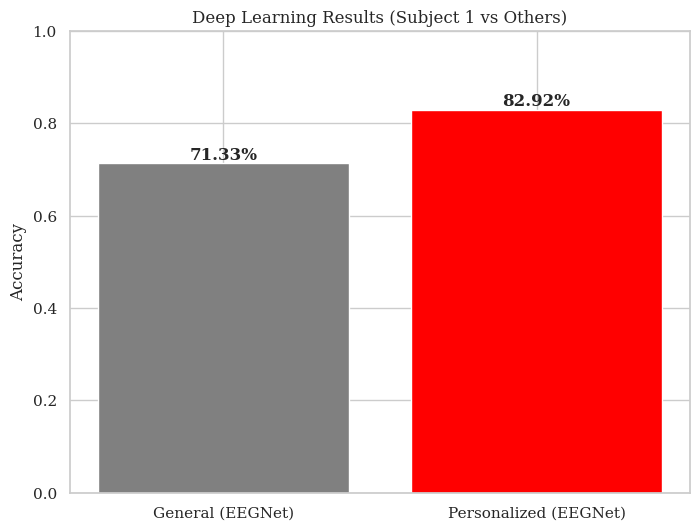

성능 향상: +11.58%p


In [ ]:
import os
import glob
import scipy.io
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from braindecode.models import EEGNetv4
import copy
import matplotlib.pyplot as plt

# GPU 사용 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 장치: {device}")


# 1. 설정 및 하이퍼파라미터
# SEED 데이터셋 라벨 시퀀스 (readme.txt 기준)
# 1: 긍정, 0: 중립, -1: 부정
SEED_LABELS = [1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

# 데이터 경로
DATA_DIR = './'

# 윈도잉 설정
FS = 200        # 샘플링 레이트
WINDOW_SEC = 4  # 4초 단위로 자르기
WINDOW_SIZE = FS * WINDOW_SEC # 800 샘플

# 2. 데이터 로드 및 전처리 함수
def load_all_seed_data(data_dir, target_subject_id=1):

    X_target, y_target = [], [] # 나 (Subject 1)
    X_source, y_source = [], [] # 타인 (Subject 2~15)

    # 폴더 내 모든 .mat 파일 찾기
    file_list = glob.glob(os.path.join(data_dir, "*.mat"))
    print(f"총 발견된 파일 개수: {len(file_list)}개")

    if len(file_list) == 0:
        print("경로 확인")
        return None, None, None, None

    for i, file_path in enumerate(file_list):
        filename = os.path.basename(file_path)

        # 파일명에서 피험자 ID 추출 (예: '1_20131027.mat' -> 1)
        try:
            subj_id = int(filename.split('_')[0])
        except:
            continue

        is_target = (subj_id == target_subject_id)

        # 진행 상황 출력 (5개마다)
        if i % 5 == 0:
            print(f"[{i}/{len(file_list)}] 데이터 처리 중... 현재 파일: {filename}")

        try:
            mat_data = scipy.io.loadmat(file_path)
        except:
            print(f"파일 로드 실패: {filename}")
            continue

        # 파일 내부의 15개 영화 클립 순회
        for key in mat_data.keys():
            # 'eeg'가 포함된 키 찾기 (예: 'djc_eeg1', 'eeg_1' 등)
            if 'eeg' in key and 'channel' not in key and 'uV' not in key:
                # 클립 번호 추출 (숫자만 추출)
                try:
                    # 문자열 뒤에서부터 숫자를 찾음
                    trial_idx = int(''.join(filter(str.isdigit, key))) - 1
                except:
                    continue

                # 라벨 가져오기 (0~14 인덱스 보호)
                if trial_idx < 0 or trial_idx >= 15: continue
                original_label = SEED_LABELS[trial_idx]

                # 중립 제거
                if original_label == 0:
                    continue

                # 라벨 변환
                # 부정(-1) -> 0, 긍정(1) -> 1
                binary_label = 0 if original_label == -1 else 1

                # Windowing
                raw_signal = mat_data[key] # (62, Time)
                n_samples = raw_signal.shape[1]

                # 4초 단위로 슬라이딩
                for start in range(0, n_samples - WINDOW_SIZE, WINDOW_SIZE):
                    end = start + WINDOW_SIZE
                    segment = raw_signal[:, start:end] # (62, 800)

                    # 간단한 정규화 (Z-score normalization per window)

                    mean = np.mean(segment, axis=1, keepdims=True)
                    std = np.std(segment, axis=1, keepdims=True)
                    segment = (segment - mean) / (std + 1e-6)

                    if is_target:
                        X_target.append(segment)
                        y_target.append(binary_label)
                    else:
                        X_source.append(segment)
                        y_source.append(binary_label)

    # 리스트 -> 넘파이 변환
    X_target = np.array(X_target, dtype=np.float32)
    y_target = np.array(y_target, dtype=np.int64)
    X_source = np.array(X_source, dtype=np.float32)
    y_source = np.array(y_source, dtype=np.int64)

    print(f"\n로드 및 전처리 완료")
    print(f"Target(나) 데이터: {X_target.shape} (클래스 0/1 비율: {np.bincount(y_target)})")
    print(f"Source(타인) 데이터: {X_source.shape} (클래스 0/1 비율: {np.bincount(y_source)})")

    return X_target, y_target, X_source, y_source

# 실행
X_target, y_target, X_source, y_source = load_all_seed_data(DATA_DIR)

# 3. 데이터셋 및 로더 생성

BATCH_SIZE = 64

# Source Data (학습용)
train_dataset = TensorDataset(torch.from_numpy(X_source), torch.from_numpy(y_source))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Target Data 분할 (Calibration 20% / Test 80%)
target_dataset = TensorDataset(torch.from_numpy(X_target), torch.from_numpy(y_target))
calib_size = int(len(target_dataset) * 0.2)
test_size = len(target_dataset) - calib_size

calib_dataset, test_dataset = random_split(target_dataset, [calib_size, test_size])

calib_loader = DataLoader(calib_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Calibration용 데이터: {len(calib_dataset)}개")
print(f"Test(검증용) 데이터: {len(test_dataset)}개")

# 4. 학습 및 평가 함수
def train(model, loader, epochs=5, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, pred = torch.max(output, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        print(f"Epoch {epoch+1} | Loss: {total_loss/len(loader):.4f} | Acc: {100*correct/total:.2f}%")

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            _, pred = torch.max(output, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# 1. General Model (타인 데이터 학습)
print("\n1. General Model 학습 (Source Data)")
model_gen = EEGNetv4(n_chans=62, n_outputs=2, n_times=WINDOW_SIZE).to(device)

# 데이터가 많으므로 Epoch을 5번 정도로 조정
train(model_gen, train_loader, epochs=5, lr=0.001)

acc_gen = evaluate(model_gen, test_loader)
print(f"General Model 결과: {acc_gen*100:.2f}%")


# 2. Personalized Model (전이 학습)
print("\n2. Personalized Model 학습 (Fine-tuning)")
model_pers = copy.deepcopy(model_gen)

# 낮은 학습률로 Fine-tuning
train(model_pers, calib_loader, epochs=15, lr=0.0002)

acc_pers = evaluate(model_pers, test_loader)
print(f"Personalized Model 결과: {acc_pers*100:.2f}%")

# 7. 최종 결과 시각화
plt.figure(figsize=(8, 6))
plt.bar(['General (EEGNet)', 'Personalized (EEGNet)'], [acc_gen, acc_pers],
        color=['gray', 'red'])
plt.ylim(0, 1.0)
plt.title(f'Deep Learning Results (Subject {SEED_LABELS[0]} vs Others)')
plt.ylabel('Accuracy')

plt.text(0, acc_gen, f'{acc_gen*100:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.text(1, acc_pers, f'{acc_pers*100:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

print(f"성능 향상: +{(acc_pers - acc_gen)*100:.2f}%p")

In [1]:
from google.colab import drive
import os
import glob
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from braindecode.models import EEGNetv4
from scipy.signal import butter, filtfilt
import copy

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. 경로 설정 (드라이브 내 실제 폴더 경로로 수정하세요)
DATA_DIR = '/content/drive/Capstone1/Preprocessed_EEG'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 장치: {device}")

# --- 이전 데이터 로드 및 모델 학습 함수들 (전과 동일) ---

def butter_bandpass_filter(data, lowcut=0.5, highcut=45.0, fs=200, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

def load_and_preprocess_raw(data_dir):
    X_list, y_list, sub_list = [], [], []
    file_list = sorted(glob.glob(os.path.join(data_dir, "*.mat")))
    SEED_LABELS = [1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]
    FS, WINDOW_SIZE = 200, 200 * 4

    print("데이터 로딩 중...")
    for file_path in file_list:
        filename = os.path.basename(file_path)
        try:
            subj_id = int(filename.split('_')[0]) - 1
        except:
            continue

        mat_data = scipy.io.loadmat(file_path)
        for key in mat_data.keys():
            if 'eeg' in key and 'channel' not in key:
                trial_idx = int(''.join(filter(str.isdigit, key))) - 1
                if trial_idx < 0 or trial_idx >= 15: continue
                if SEED_LABELS[trial_idx] == 0: continue

                label = 1 if SEED_LABELS[trial_idx] == 1 else 0
                raw = butter_bandpass_filter(mat_data[key])
                for s in range(0, raw.shape[1] - WINDOW_SIZE, WINDOW_SIZE):
                    seg = raw[:, s:s+WINDOW_SIZE]
                    seg = (seg - np.mean(seg)) / (np.std(seg) + 1e-6)
                    X_list.append(seg)
                    y_list.append(label)
                    sub_list.append(subj_id)
    return np.array(X_list, dtype=np.float32), np.array(y_list), np.array(sub_list)

# --- 메인 실행 로직 ---
X, y, subjects = load_and_preprocess_raw(DATA_DIR)

# 이후 학습 로직은 이전과 동일하게 진행 (GPU에서 매우 빠르게 돌아갑니다)

Mounted at /content/drive
현재 사용 중인 장치: cuda
데이터 로딩 중...


In [1]:
!pip install braindecode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.8/448.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 117.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
dask-cudf-cu12 25.10